In [1]:
#预测房价中位数
import os
import tarfile
from six.moves import urllib

In [2]:
root_path = 'E:/ipython notebook/handson_ml/'
tgz_path = os.path.join(root_path, 'housing.tgz')
#解压文件
housing_tgz = tarfile.open(tgz_path)
housing_tgz.extractall()
housing_tgz.close()

In [3]:
import pandas as pd


def load_housing_data(housing_path=root_path):
    csv_path = os.path.join(root_path,'housing.csv')
    return pd.read_csv(csv_path)

In [4]:
housing = load_housing_data()

In [5]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [6]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [7]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [8]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


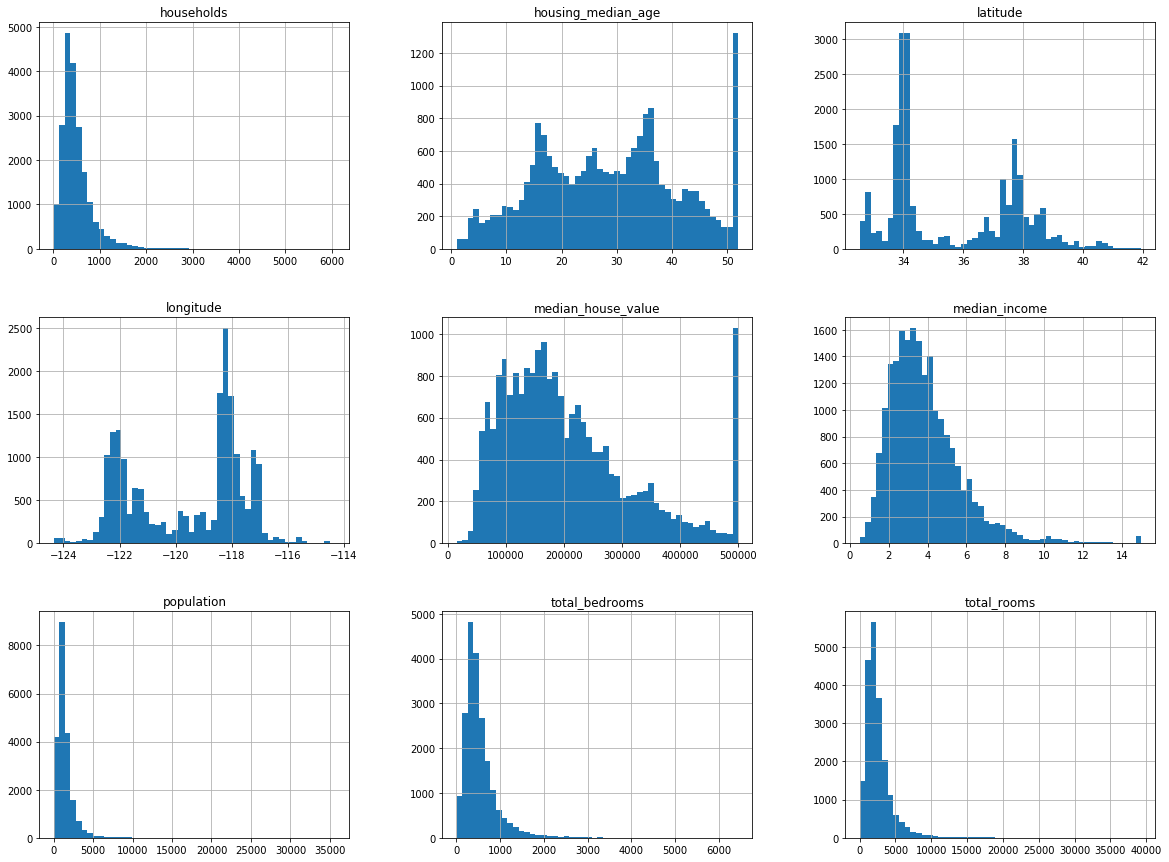

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins = 50, figsize=(20,15))
plt.show()

In [10]:
#创建测试集
import numpy as np

def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [11]:
train_set_1, test_set_1 = split_train_test(housing, 0.2)
print len(train_set_1),"train+",len(test_set_1),"test"

16512 train+ 4128 test


In [12]:
#确保每次运行程序，切分数据集得到相同的测试集和训练集，可以在调用np.random.permutation()之前，设置随机数生成器的种子（比如，np.random.seed(42)），以产生总是相同的洗牌指数 (shuffled indices)
#但是如果数据集更新，这个方法失效。
#一个通常的解决办法是使用每个实例的ID来判定这个实例是否应该放入测试集（假设每个实例都有唯一并且不变的ID）。
#例如，你可以计算出每个实例ID的哈希值，只保留其最后一个字节，如果该值小于等于 51（约为 256 的 20%），就将其放入测试集。
#这样可以保证在多次运行中，测试集保持不变，即使更新了数据集。新的测试集会包含新实例中的 20%，但不会有之前位于训练集的实例。
#hashlib 在python2中不支持
import hashlib

def test_set_check(identifier, test_ratio, hash):
    #hash.digest() 返回摘要，作为二进制数据字符串值
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio

def split_train_test_by_id(data, test_ratio, id_column, hash=hashlib.md5):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio, hash))
    return data.loc[~in_test_set], data.loc[in_test_set]



In [13]:
from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [14]:
housing_with_id = housing.reset_index() #adds an index column
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

In [15]:
test_set.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
2,2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
5,5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
12,12,-122.26,37.85,52.0,2491.0,474.0,1098.0,468.0,3.0750,213500.0,NEAR BAY
16,16,-122.27,37.85,52.0,1966.0,347.0,793.0,331.0,2.7750,152500.0,NEAR BAY
23,23,-122.27,37.84,52.0,1688.0,337.0,853.0,325.0,2.1806,99700.0,NEAR BAY


In [16]:
#scikit_learn 切分数据集
from sklearn.model_selection import train_test_split

train_set_2, test_set_2 = train_test_split(housing, test_size=0.2, random_state=42)

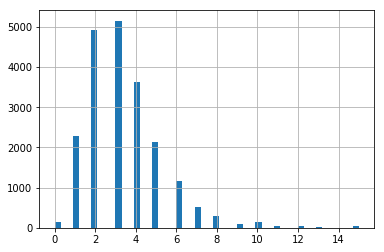

In [17]:
housing_income =housing['median_income'].apply(lambda x:int(x))
housing_income.hist(bins = 50)

In [18]:
#为了避免采样偏差，分层抽样，不能有过多的分层，且每个分层都要有足够大
#通过将收入中位数除以 1.5（以限制收入分类的数量），创建了一个收入类别属性，用ceil对值舍入（以产生离散的分类），然后将所有大于 5的分类归入到分类 5：
housing["income_cat"] = np.ceil(housing['median_income']/1.5)
#pandas.series.where() ,将不满足条件的值进行替换，返回相同大小的series
housing['income_cat'].where(housing['income_cat'] < 5, 5.0, inplace=True)


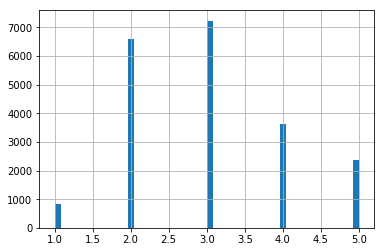

In [19]:
housing['income_cat'].hist(bins=50)

In [20]:
housing['income_cat'].value_counts()

3.0    7236
2.0    6581
4.0    3639
5.0    2362
1.0     822
Name: income_cat, dtype: int64

In [21]:
#现在根据收入分类，进行分层采样。
from sklearn.model_selection import StratifiedShuffleSplit

#StratifiedShuffleSplit方法中的n_splits参数是将训练数据分成train/test对的组数
ss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

#ss.split(x, y) 将特征和标签进行切分训练集和测试集
for train_index, test_index in ss.split(housing, housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]
    

In [22]:
def income_cat_proporitions(data):
    return data['income_cat'].value_counts()/len(data)

compare_props = pd.DataFrame({
    "overall":income_cat_proporitions(housing),
    "stratified":income_cat_proporitions(strat_test_set),
    #"split_train_test_by_id":income_cat_proporitions(test_set),
    #"train_test_split":income_cat_proporitions(test_set_2),
    #"split_train_test":income_cat_proporitions(test_set_1),
 }).sort_index()

In [23]:
compare_props

,overall,stratified
1.0,0.039826,0.039729
2.0,0.318847,0.318798
3.0,0.350581,0.350533
4.0,0.176308,0.176357
5.0,0.114438,0.114583


In [24]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop(['income_cat'], axis=1, inplace=True)

In [25]:
#数据探索与可视化、发现规律
#只研究训练集
housing = strat_train_set.copy()


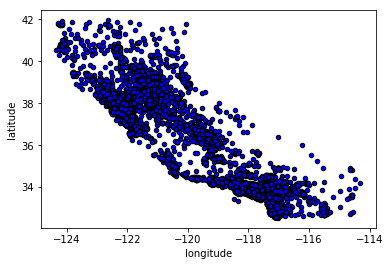

In [26]:
#数据地理位置可视化
#edgecolors设置圆圈边的颜色
#c设置圆圈内的颜色
housing.plot(kind='scatter', x='longitude',y = 'latitude',edgecolors='black',c='b')

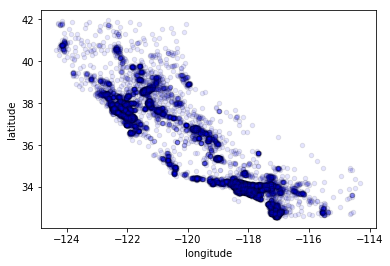

In [27]:
#设置alpha可以更容易看出数据点的密度
housing.plot(kind='scatter', x='longitude',y = 'latitude', alpha=0.1,edgecolors='black',c='b')

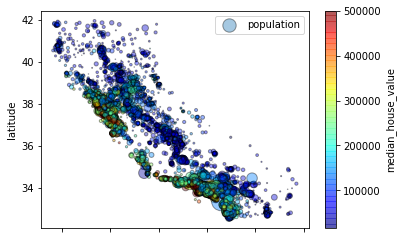

In [28]:
#可视化房价
#每个圈的半径表示街区的人口（选项s），颜色代表价格（选项c）。我们用预先定义的名为jet的颜色图（选项cmap），它的范围是从蓝色（低价）到红色（高价）

housing.plot(kind='scatter', x='longitude', y='latitude',alpha=0.4,
            s=housing['population']/100, label='population',
            c='median_house_value',cmap=plt.get_cmap('jet'),
            colorbar=True,
            edgecolors='black')
plt.legend()

In [29]:
#查找关联
#使用corr()计算出每对属性间的标准相关系数（皮尔逊相关系数），只能看出线性相关关系
corr_matrix = housing.corr()

In [30]:
corr_matrix

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924478,-0.105848,0.048871,0.076598,0.108030,0.063070,-0.019583,-0.047432
latitude,-0.924478,1.000000,0.005766,-0.039184,-0.072419,-0.115222,-0.077647,-0.075205,-0.142724
housing_median_age,-0.105848,0.005766,1.000000,-0.364509,-0.325047,-0.298710,-0.306428,-0.111360,0.114110
total_rooms,0.048871,-0.039184,-0.364509,1.000000,0.929379,0.855109,0.918392,0.200087,0.135097
total_bedrooms,0.076598,-0.072419,-0.325047,0.929379,1.000000,0.876320,0.980170,-0.009740,0.047689
population,0.108030,-0.115222,-0.298710,0.855109,0.876320,1.000000,0.904637,0.002380,-0.026920
households,0.063070,-0.077647,-0.306428,0.918392,0.980170,0.904637,1.000000,0.010781,0.064506
median_income,-0.019583,-0.075205,-0.111360,0.200087,-0.009740,0.002380,0.010781,1.000000,0.687160
median_house_value,-0.047432,-0.142724,0.114110,0.135097,0.047689,-0.026920,0.064506,0.687160,1.000000


In [31]:
#看每个属性和房价中位数的相关度
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

d:\python27\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: 'pandas.tools.plotting.scatter_matrix' is deprecated, import 'pandas.plotting.scatter_matrix' instead.
  import sys


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000000135DE518>,
      dtype=object)

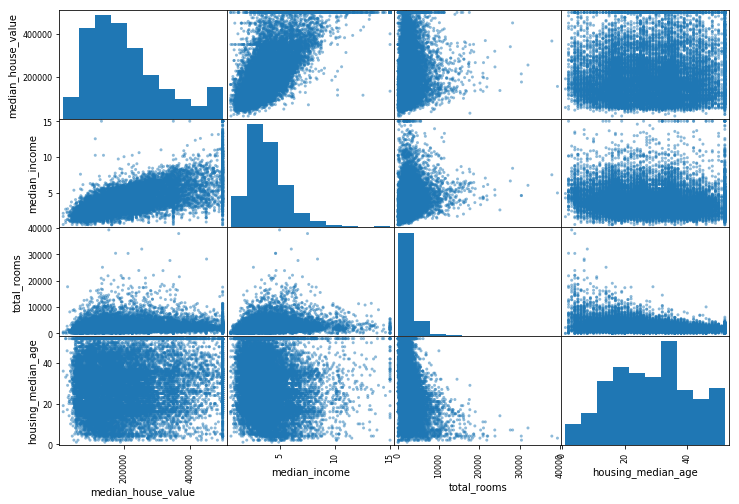

In [32]:
#另一种检测属性间相关系数的方法是使用 Pandas 的scatter_matrix函数，它能画出每个数值属性对每个其它数值属性的图。

from pandas.tools.plotting import scatter_matrix

attributes = ['median_house_value','median_income','total_rooms', 'housing_median_age']

scatter_matrix(housing[attributes], figsize=(12, 8))

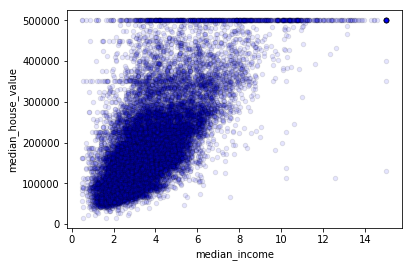

In [33]:
#可以看出收入中位数与房价中位数有一定的相关关度
housing.plot(kind='scatter', x='median_income',y='median_house_value',
            alpha=0.1,edgecolors='black',c='b')

In [34]:
#属性组合试验

housing['rooms_per_household'] = housing['total_rooms']/housing['households']
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [35]:
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

In [36]:
#为机器学习算法准备数据

housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set['median_house_value'].copy()

In [37]:
#数据清洗
#total_bedrooms有缺失值，三种解决选项：1 去掉对应的街区，2 去掉整个属性， 3 进行填充（0，均值，中位数等等）
#pandas的DataFrame的dropna(), drop(), fillna()方法分别可以实现
# 如果是中位数填充，需要保持该中位数，后面测试集需要测试集中的缺失值

#scikit_learn提供缺失值处理的类，Imputer.

from sklearn.preprocessing import Imputer

imputer = Imputer(strategy='median')


In [38]:
#处理文本属性 ocean_proximity
housing_num=housing.drop(['ocean_proximity'], axis=1)

imputer.fit(housing_num)

Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)

In [39]:
#imputer计算出每个属性的中位数，将结果保存在实例变量 statistics_
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [40]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [41]:
#使用imputer 对训练集进行转换，将缺失值替换为中位数，结果是numpy 数组
x = imputer.transform(housing_num)

housing_tr = pd.DataFrame(x, columns=housing_num.columns)

In [42]:
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042
1,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214
2,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621
3,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839
4,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347


In [44]:
#处理文本和类别属性

from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
housing_cat = housing['ocean_proximity']
#fit_transform()方法等同于先fit()方法后transtorm()方法的合并，但有时fit_transform()经过优化，运行的更快
housing_cat_encoded = encoder.fit_transform(housing_cat)
print housing_cat
print housing_cat_encoded

17606     <1H OCEAN
18632     <1H OCEAN
14650    NEAR OCEAN
3230         INLAND
3555      <1H OCEAN
19480        INLAND
8879      <1H OCEAN
13685        INLAND
4937      <1H OCEAN
4861      <1H OCEAN
16365        INLAND
19684        INLAND
19234     <1H OCEAN
13956        INLAND
2390         INLAND
11176     <1H OCEAN
15614      NEAR BAY
2953         INLAND
13209        INLAND
6569         INLAND
5825      <1H OCEAN
18086     <1H OCEAN
16718     <1H OCEAN
13600        INLAND
13989        INLAND
15168     <1H OCEAN
6747      <1H OCEAN
7398      <1H OCEAN
5562      <1H OCEAN
16121      NEAR BAY
            ...    
12380        INLAND
5618     NEAR OCEAN
10060        INLAND
18067     <1H OCEAN
4471      <1H OCEAN
19786        INLAND
9969         INLAND
14621    NEAR OCEAN
579        NEAR BAY
11682     <1H OCEAN
245        NEAR BAY
12130        INLAND
16441        INLAND
11016     <1H OCEAN
19934        INLAND
1364       NEAR BAY
1236         INLAND
5364      <1H OCEAN
11703     <1H OCEAN


In [45]:
#编码器是通过属性classes_来学习的
encoder.classes_

array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
      dtype=object)

In [46]:
#对于多个文本特征列的时候，LabelEncoder将会出错
#应该使用factorize()方法

housing_cat_encoded, housing_categories = housing_cat.factorize()

housing_cat_encoded

array([0, 0, 1, ..., 2, 0, 3], dtype=int64)

In [47]:
housing_categories

Index([u'<1H OCEAN', u'NEAR OCEAN', u'INLAND', u'NEAR BAY', u'ISLAND'], dtype='object')

In [48]:
#以上编码存在的问题是：ml算法会认为两个临近的值比两个疏远的值更相似。就是说数值的大小表示某种关系，这显然是不对的
#scikit_learn提供OneHotEncoder，独热编码

#注意fit_transform()用于2D数组，housing_cat_encoded是1D数组,变形housing_cat_encoded.reshape(-1, 1)

from sklearn.preprocessing import OneHotEncoder
#OneHotEncoder()方法默认返回稀疏矩阵，如果需要返回密集矩阵，加入参数sparse=False
encoder = OneHotEncoder()
#reshape(-1,1)表示数组新的shape属性应该要与原来的配套，
#如果等于-1的话，那么Numpy会根据剩下的维度计算出数组的另外一个shape属性值,
#不管原来shape是多少（x,y），变成（x*y, 1）一列
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1, 1))
print housing_cat_encoded.reshape(-1, 1).shape
print housing_cat_1hot

(16512L, 1L)
  (0, 0)	1.0
  (1, 0)	1.0
  (2, 1)	1.0
  (3, 2)	1.0
  (4, 0)	1.0
  (5, 2)	1.0
  (6, 0)	1.0
  (7, 2)	1.0
  (8, 0)	1.0
  (9, 0)	1.0
  (10, 2)	1.0
  (11, 2)	1.0
  (12, 0)	1.0
  (13, 2)	1.0
  (14, 2)	1.0
  (15, 0)	1.0
  (16, 3)	1.0
  (17, 2)	1.0
  (18, 2)	1.0
  (19, 2)	1.0
  (20, 0)	1.0
  (21, 0)	1.0
  (22, 0)	1.0
  (23, 2)	1.0
  (24, 2)	1.0
  :	:
  (16487, 2)	1.0
  (16488, 2)	1.0
  (16489, 1)	1.0
  (16490, 3)	1.0
  (16491, 0)	1.0
  (16492, 3)	1.0
  (16493, 2)	1.0
  (16494, 2)	1.0
  (16495, 0)	1.0
  (16496, 2)	1.0
  (16497, 3)	1.0
  (16498, 2)	1.0
  (16499, 0)	1.0
  (16500, 0)	1.0
  (16501, 0)	1.0
  (16502, 1)	1.0
  (16503, 0)	1.0
  (16504, 2)	1.0
  (16505, 2)	1.0
  (16506, 0)	1.0
  (16507, 2)	1.0
  (16508, 2)	1.0
  (16509, 2)	1.0
  (16510, 0)	1.0
  (16511, 3)	1.0


In [49]:
# onehotencoder 结果是 SciPy 稀疏矩阵，稀疏矩阵只存储非零元素的位置。你可以像一个 2D 数据那样进行使用，但是如果你真的想将其转变成一个（密集的）NumPy 数组，只需调用toarray()方法

housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [50]:
#使用LabelBinarizer,可以执行两个转换过程（从文本分类到整数分类，再从整数分类到独热向量）
#类LabelBinarizer默认返回密集numpy数据，如果要得到稀疏矩阵，加入参数sparse_output=True
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()
housing_cat_1hot = encoder.fit_transform(housing_cat)

housing_cat_1hot

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       ...,
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0]])

In [51]:
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer(sparse_output=True)
housing_cat_1hot = encoder.fit_transform(housing_cat)

print housing_cat_1hot

  (0, 0)	1
  (1, 0)	1
  (2, 4)	1
  (3, 1)	1
  (4, 0)	1
  (5, 1)	1
  (6, 0)	1
  (7, 1)	1
  (8, 0)	1
  (9, 0)	1
  (10, 1)	1
  (11, 1)	1
  (12, 0)	1
  (13, 1)	1
  (14, 1)	1
  (15, 0)	1
  (16, 3)	1
  (17, 1)	1
  (18, 1)	1
  (19, 1)	1
  (20, 0)	1
  (21, 0)	1
  (22, 0)	1
  (23, 1)	1
  (24, 1)	1
  :	:
  (16487, 1)	1
  (16488, 1)	1
  (16489, 4)	1
  (16490, 3)	1
  (16491, 0)	1
  (16492, 3)	1
  (16493, 1)	1
  (16494, 1)	1
  (16495, 0)	1
  (16496, 1)	1
  (16497, 3)	1
  (16498, 1)	1
  (16499, 0)	1
  (16500, 0)	1
  (16501, 0)	1
  (16502, 4)	1
  (16503, 0)	1
  (16504, 1)	1
  (16505, 1)	1
  (16506, 0)	1
  (16507, 1)	1
  (16508, 1)	1
  (16509, 1)	1
  (16510, 0)	1
  (16511, 3)	1


In [52]:
# 自定义转换器, 将组合属性加入到训练数据中

from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

#这个类不是很明白
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]   
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [53]:


housing_extra_attribs 

array([[-121.89, 37.29, 38.0, ..., '<1H OCEAN', 4.625368731563422,
        2.094395280235988],
       [-121.93, 37.05, 14.0, ..., '<1H OCEAN', 6.008849557522124,
        2.7079646017699117],
       [-117.2, 32.77, 31.0, ..., 'NEAR OCEAN', 4.225108225108225,
        2.0259740259740258],
       ...,
       [-116.4, 34.09, 9.0, ..., 'INLAND', 6.34640522875817,
        2.742483660130719],
       [-118.01, 33.82, 31.0, ..., '<1H OCEAN', 5.50561797752809,
        3.808988764044944],
       [-122.45, 37.77, 52.0, ..., 'NEAR BAY', 4.843505477308295,
        1.9859154929577465]], dtype=object)

In [54]:
# 特征缩放
#常用方法（线性函数归一化，标准化）
#scikit_learn 中MinMaxScaler实现归一化，它有个超参数feature_range,可以改变范围
#scikit_learn 中StandardScaler 实现标准化



In [55]:
#转换流水线，scikit_learn提供类pipeline进行一系列转换
#Pipeline构造器需要一个定义步骤顺序的名字/估计器对的列表。
#除了最后一个估计器，其余都要是转换器（即，它们都要有fit_transform()方法）。
#名字可以随意起。
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('inputer', Imputer(strategy='median')),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [56]:
from sklearn.base import BaseEstimator, TransformerMixin

# Create a class to select numerical or categorical columns 
class OldDataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [57]:
from sklearn.pipeline import FeatureUnion

num_attribs = list(housing_num)
cat_attribs = ['ocean_proximity']

num_pipeline = Pipeline([
    ('selector', OldDataFrameSelector(num_attribs)),
    ('imputer', Imputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),    
])

cat_pipeline = Pipeline([
    ('selector', OldDataFrameSelector(cat_attribs)),
    #('label_binarizer', LabelBinarizer()),
])

full_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    ("cat_pipeline", cat_pipeline),
])

In [58]:
housing_prepared = full_pipeline.fit_transform(housing)

In [59]:
housing_prepared = pd.DataFrame(housing_prepared)

In [60]:
housing_prepared.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,-1.15604,0.77195,0.743331,-0.493234,-0.445438,-0.636211,-0.420698,-0.614937,-0.312055,-0.0864987,0.155318,<1H OCEAN
1,-1.17602,0.659695,-1.16532,-0.908967,-1.03693,-0.998331,-1.02223,1.33646,0.217683,-0.0335339,-0.836289,<1H OCEAN
2,1.18685,-1.34218,0.186642,-0.31366,-0.153345,-0.433639,-0.0933178,-0.532046,-0.465315,-0.092405,0.4222,NEAR OCEAN
3,-0.0170677,0.313576,-0.29052,-0.362762,-0.396756,0.036041,-0.383436,-1.04557,-0.0796612,0.0897356,-0.196453,INLAND
4,0.492474,-0.659299,-0.926736,1.85619,2.41221,2.72415,2.57097,-0.441437,-0.357834,-0.00419445,0.269928,<1H OCEAN


In [61]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [62]:
housing_prepared.drop(int(11), axis=1,inplace = True)

In [63]:
housing_prepared.head()

,0,1,2,3,4,5,6,7,8,9,10
0,-1.15604,0.77195,0.743331,-0.493234,-0.445438,-0.636211,-0.420698,-0.614937,-0.312055,-0.0864987,0.155318
1,-1.17602,0.659695,-1.16532,-0.908967,-1.03693,-0.998331,-1.02223,1.33646,0.217683,-0.0335339,-0.836289
2,1.18685,-1.34218,0.186642,-0.31366,-0.153345,-0.433639,-0.0933178,-0.532046,-0.465315,-0.092405,0.4222
3,-0.0170677,0.313576,-0.29052,-0.362762,-0.396756,0.036041,-0.383436,-1.04557,-0.0796612,0.0897356,-0.196453
4,0.492474,-0.659299,-0.926736,1.85619,2.41221,2.72415,2.57097,-0.441437,-0.357834,-0.00419445,0.269928


In [64]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)



LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [65]:
some_data = housing_prepared.iloc[:5]
some_labels = housing_labels.iloc[:5]
print "predictions:\t",lin_reg.predict(some_data)

predictions:	[206563.06068576 318589.03841011 206073.20582883  71351.11544056
 185692.95569414]


In [66]:
print list(some_labels)

[286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [67]:
#计算全部数据的rmse

from sklearn.metrics import mean_squared_error

hosing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, hosing_predictions)
lin_rmse = np.sqrt(lin_mse)
print lin_mse
print lin_rmse

4819536492.105021
69422.88161769879


In [68]:
#线性回归欠拟合， 需要选择一个更复杂的模型
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [69]:
housing_predicitions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predicitions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

In [70]:
#进行交叉验证, 交叉验证的功能期望效用函数越大越好
from sklearn.model_selection import cross_val_score

score = cross_val_score(tree_reg, housing_prepared, housing_labels,
                       scoring='neg_mean_squared_error', cv=10)

rmse_scores = np.sqrt(-score)

In [71]:
rmse_scores

array([70903.16656864, 73032.0453855 , 72823.93195712, 74122.45039948,
       74935.78203289, 74606.90461771, 72014.51626861, 72137.63798275,
       73419.6983978 , 75578.76822297])

In [72]:
rmse_scores.mean()

73357.49018334664

In [73]:
rmse_scores.std()

1388.5630394236284

In [74]:
def display_scores(scores):
    print "Scores:",scores
    print "Mean:",scores.mean()
    print "std:",scores.std()

In [75]:
display_scores(rmse_scores)

Scores: [70903.16656864 73032.0453855  72823.93195712 74122.45039948
 74935.78203289 74606.90461771 72014.51626861 72137.63798275
 73419.6983978  75578.76822297]
Mean: 73357.49018334664
std: 1388.5630394236284


In [76]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
               scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [67383.78417581 67985.10139708 72048.46844728 74992.50810742
 68535.66280489 71602.89821633 66059.1201932  69302.44278968
 72437.02688935 68368.6996472 ]
Mean: 69871.57126682387
std: 2630.4324574585094


In [77]:
from sklearn.ensemble import RandomForestRegressor

forest_ret = RandomForestRegressor()
forest_ret.fit(housing_prepared, housing_labels)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [78]:
rf_scores = cross_val_score(forest_ret, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
rf_rmse_scores = np.sqrt(-rf_scores)
display_scores(rf_rmse_scores)

Scores: [53279.20607636 51709.74797867 53588.07179839 55182.65777897
 53520.13955032 56132.94850139 52246.77975255 53454.86481308
 56636.94807935 53546.07070721]
Mean: 53929.74350362999
std: 1503.131353509625


In [79]:
#保存模型
from sklearn.externals import joblib

joblib.dump(my_model, "my_model.pkl")
#加载以保存的模型
my_model_loaded = joblib.load("my_model.pkl")

NameError: name 'my_model' is not defined

In [80]:
#模型微调——网格搜索

from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features':[2, 4, 6, 8]},
    {'bootstrap':[False], 'n_estimators':[3, 10], 'max_features':[2,3,4]},
]
forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                          scoring='neg_mean_squared_error',verbose=10)

grid_search.fit(housing_prepared, housing_labels)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] max_features=2, n_estimators=3 ..................................
[CV]  max_features=2, n_estimators=3, score=-4302645856.54, total=   0.0s
[CV] max_features=2, n_estimators=3 ..................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


[CV]  max_features=2, n_estimators=3, score=-4550612938.52, total=   0.0s
[CV] max_features=2, n_estimators=3 ..................................
[CV]  max_features=2, n_estimators=3, score=-4241916126.08, total=   0.0s
[CV] max_features=2, n_estimators=3 ..................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s


[CV]  max_features=2, n_estimators=3, score=-4252983344.13, total=   0.0s
[CV] max_features=2, n_estimators=3 ..................................
[CV]  max_features=2, n_estimators=3, score=-4424826622.18, total=   0.0s
[CV] max_features=2, n_estimators=10 .................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s remaining:    0.0s


[CV]  max_features=2, n_estimators=10, score=-3237803181.8, total=   0.2s
[CV] max_features=2, n_estimators=10 .................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.8s remaining:    0.0s


[CV]  max_features=2, n_estimators=10, score=-3281516991.26, total=   0.2s
[CV] max_features=2, n_estimators=10 .................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    1.2s remaining:    0.0s


[CV]  max_features=2, n_estimators=10, score=-3323992727.25, total=   0.2s
[CV] max_features=2, n_estimators=10 .................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    1.6s remaining:    0.0s


[CV]  max_features=2, n_estimators=10, score=-3393907756.79, total=   0.3s
[CV] max_features=2, n_estimators=10 .................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    2.0s remaining:    0.0s


[CV]  max_features=2, n_estimators=10, score=-3443579648.8, total=   0.3s
[CV] max_features=2, n_estimators=30 .................................
[CV]  max_features=2, n_estimators=30, score=-2793231597.98, total=   1.0s
[CV] max_features=2, n_estimators=30 .................................
[CV]  max_features=2, n_estimators=30, score=-2933648601.99, total=   0.9s
[CV] max_features=2, n_estimators=30 .................................
[CV]  max_features=2, n_estimators=30, score=-2975287708.36, total=   0.9s
[CV] max_features=2, n_estimators=30 .................................
[CV]  max_features=2, n_estimators=30, score=-2764445950.31, total=   0.9s
[CV] max_features=2, n_estimators=30 .................................
[CV]  max_features=2, n_estimators=30, score=-3099845969.61, total=   0.9s
[CV] max_features=4, n_estimators=3 ..................................
[CV]  max_features=4, n_estimators=3, score=-3960284134.11, total=   0.1s
[CV] max_features=4, n_estimators=3 ...............

[CV]  max_features=2, n_estimators=10, bootstrap=False, score=-3033972792.76, total=   0.3s
[CV] max_features=2, n_estimators=10, bootstrap=False ................
[CV]  max_features=2, n_estimators=10, bootstrap=False, score=-3065594611.58, total=   0.3s
[CV] max_features=2, n_estimators=10, bootstrap=False ................
[CV]  max_features=2, n_estimators=10, bootstrap=False, score=-3093967183.41, total=   0.3s
[CV] max_features=2, n_estimators=10, bootstrap=False ................
[CV]  max_features=2, n_estimators=10, bootstrap=False, score=-3274924441.07, total=   0.3s
[CV] max_features=2, n_estimators=10, bootstrap=False ................
[CV]  max_features=2, n_estimators=10, bootstrap=False, score=-3110943333.35, total=   0.3s
[CV] max_features=3, n_estimators=3, bootstrap=False .................
[CV]  max_features=3, n_estimators=3, bootstrap=False, score=-3443698910.4, total=   0.1s
[CV] max_features=3, n_estimators=3, bootstrap=False .................
[CV]  max_features=3, n_

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  1.1min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, {'n_estimators': [3, 10], 'max_features': [2, 3, 4], 'bootstrap': [False]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=10)

In [81]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [82]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=6, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [83]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print np.sqrt(-mean_score), params

65989.43629359675 {'max_features': 2, 'n_estimators': 3}
57759.421700648694 {'max_features': 2, 'n_estimators': 10}
53974.86384783709 {'max_features': 2, 'n_estimators': 30}
61965.68340790209 {'max_features': 4, 'n_estimators': 3}
54955.01217218979 {'max_features': 4, 'n_estimators': 10}
52099.399954458524 {'max_features': 4, 'n_estimators': 30}
60658.582464099185 {'max_features': 6, 'n_estimators': 3}
53293.48116795093 {'max_features': 6, 'n_estimators': 10}
51590.93284801344 {'max_features': 6, 'n_estimators': 30}
61356.383487857616 {'max_features': 8, 'n_estimators': 3}
54036.82519738025 {'max_features': 8, 'n_estimators': 10}
51910.059029427706 {'max_features': 8, 'n_estimators': 30}
63912.083673715475 {'max_features': 2, 'n_estimators': 3, 'bootstrap': False}
55820.00059589767 {'max_features': 2, 'n_estimators': 10, 'bootstrap': False}
59198.972267578494 {'max_features': 3, 'n_estimators': 3, 'bootstrap': False}
53991.74632120232 {'max_features': 3, 'n_estimators': 10, 'bootstrap'

In [88]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

numpy.ndarray

In [91]:
print feature_importances
print num_attribs

[0.09663759 0.0958799  0.05155209 0.01676371 0.01579357 0.01614297
 0.01509039 0.42684579 0.05017271 0.12675332 0.08836795]
['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']


In [87]:
#将重要性分数和属性名放到一起,feature_importances没有进行排序所以与属性名对应

attributes = num_attribs + ['rooms_per_hhold', "pop_per_hhold", "bedrooms_per_room"]
sorted(zip(feature_importances, attributes), reverse=True)

[(0.42684578939413703, 'median_income'),
 (0.1267533199611686, 'pop_per_hhold'),
 (0.09663759423246097, 'longitude'),
 (0.09587990141682294, 'latitude'),
 (0.0883679468411044, 'bedrooms_per_room'),
 (0.051552091932781416, 'housing_median_age'),
 (0.05017270927579449, 'rooms_per_hhold'),
 (0.016763714307697953, 'total_rooms'),
 (0.016142965002157218, 'population'),
 (0.01579357339444961, 'total_bedrooms'),
 (0.01509039424142538, 'households')]